Первые 5 строк датасета:


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1



Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_ris

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000



Распределение целевой переменной 'default':
default
0    1769
1    1231
Name: count, dtype: int64

Доли классов:
default
0    0.589667
1    0.410333
Name: proportion, dtype: float64


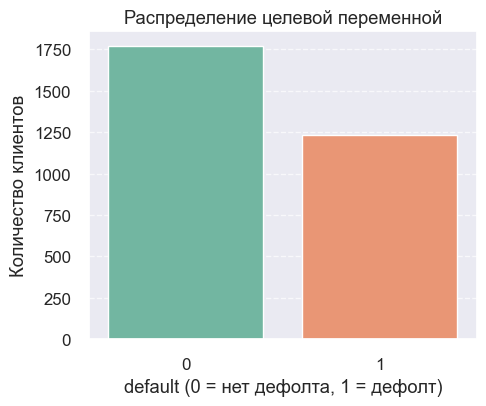

- Всего объектов: 3000
- Признаков (без client_id и target): 15
- Доля дефолтов (class=1): 41.0% (~0.70 : 1)
- Данные полностью числовые — сложной предобработки не требуется.
Матрица признаков X: (3000, 15)
Вектор таргета y: (3000,)

Размер обучающей выборки: 2400
Размер тестовой выборки:   600
Бейзлайн (DummyClassifier — 'most_frequent'):
  Accuracy:  0.5900
  ROC-AUC:   0.5000

 Пояснение: бейзлайн всегда предсказывает '0' (нет дефолта),
   так как этот класс встречается чаще (~60%).
   ROC-AUC = 0.5 означает, что модель не лучше случайного угадывания.
Подбор гиперпараметра C:
  Лучшее значение C: 100.0
  Лучший CV ROC-AUC: 0.8607

 Тестовые метрики для LogisticRegression (C=100.0):
  Accuracy:   0.8017
  ROC-AUC:    0.8756
  Precision:  0.7953
  Recall:     0.6951
  F1-score:   0.7419


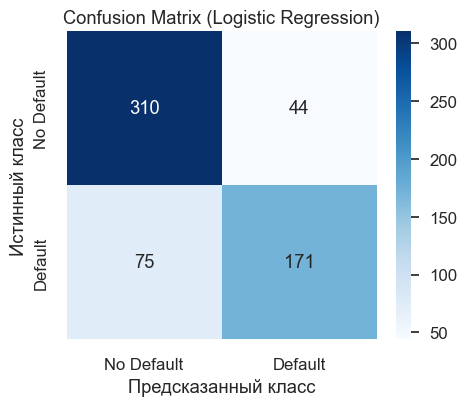

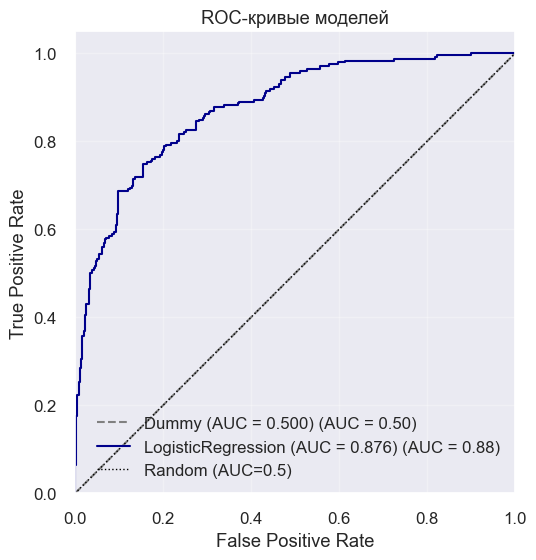

 ROC-кривая сохранена: figures/shavel.png
Сравнение моделей на тестовой выборке:


,Model,Accuracy,ROC-AUC,Precision,Recall,F1-score
0,DummyClassifier,0.5900,0.5000,0.0000,0.0000,0.0000
1,LogisticRegression,0.8017,0.8756,0.7953,0.6951,0.7419


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, 
    precision_score, recall_score, f1_score,
    confusion_matrix, RocCurveDisplay, classification_report
)
from sklearn.exceptions import UndefinedMetricWarning
import warnings
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
plt.style.use('seaborn-v0_8')
sns.set(font_scale=1.1)
pd.set_option('display.max_columns', None)
df = pd.read_csv("../datasets/HW5/S05-hw-dataset.csv")
print("Первые 5 строк датасета:")
display(df.head())
print("\nИнформация о датасете:")
df.info()
print("\nОписательная статистика (числовые признаки):")
display(df.describe())
print("\nРаспределение целевой переменной 'default':")
target_counts = df['default'].value_counts()
target_ratios = df['default'].value_counts(normalize=True)
print(target_counts)
print("\nДоли классов:")
print(target_ratios)
plt.figure(figsize=(5, 4))
sns.countplot(data=df, x='default', hue='default', palette='Set2', legend=False)
plt.title('Распределение целевой переменной')
plt.xlabel('default (0 = нет дефолта, 1 = дефолт)')
plt.ylabel('Количество клиентов')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
n_samples, n_features = df.shape[0], df.shape[1] - 1 
n_positive = target_counts[1]
imbalance_ratio = n_positive / (n_samples - n_positive)
print(f"- всего объектов: {n_samples}")
print(f"- Признаков (без client_id и target): {n_features - 1}") 
print(f"- Доля дефолтов (class=1): {target_ratios[1]:.1%} (~{imbalance_ratio:.2f} : 1)")
print(f"- Данные полностью числовые — сложной предобработки не требуется.")
feature_columns = [col for col in df.columns if col not in ['client_id', 'default']]
X = df[feature_columns]
y = df['default']
print(f"Матрица признаков X: {X.shape}")
print(f"Вектор таргета y: {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки:   {X_test.shape[0]}")
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]
acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)
print("Бейзлайн (DummyClassifier — 'most_frequent'):")
print(f"  Accuracy:  {acc_dummy:.4f}")
print(f"  ROC-AUC:   {auc_dummy:.4f}")
print("\n Пояснение: бейзлайн всегда предсказывает '0' (нет дефолта),")
print("   так как этот класс встречается чаще (~60%).")
print("   ROC-AUC = 0.5 означает, что модель не лучше случайного угадывания.")
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
])
param_grid = {'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=0
)
grid_search.fit(X_train, y_train)
best_pipe = grid_search.best_estimator_
best_C = grid_search.best_params_['logreg__C']
best_cv_auc = grid_search.best_score_
print("Подбор гиперпараметра C:")
print(f"  Лучшее значение C: {best_C}")
print(f"  Лучший CV ROC-AUC: {best_cv_auc:.4f}")
y_pred_lr = best_pipe.predict(X_test)
y_proba_lr = best_pipe.predict_proba(X_test)[:, 1]
acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print(f"\n Тестовые метрики для LogisticRegression (C={best_C}):")
print(f"  Accuracy:   {acc_lr:.4f}")
print(f"  ROC-AUC:    {auc_lr:.4f}")
print(f"  Precision:  {prec_lr:.4f}")
print(f"  Recall:     {rec_lr:.4f}")
print(f"  F1-score:   {f1_lr:.4f}")
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

os.makedirs("figures", exist_ok=True)
plt.figure(figsize=(7, 6))

RocCurveDisplay.from_predictions(
    y_test, y_proba_dummy,
    name=f"Dummy (AUC = {auc_dummy:.3f})",
    ax=plt.gca(),
    curve_kwargs={'color': 'gray', 'linestyle': '--'}
)

RocCurveDisplay.from_predictions(
    y_test, y_proba_lr,
    name=f"LogisticRegression (AUC = {auc_lr:.3f})",
    ax=plt.gca(),
    curve_kwargs={'color': 'darkblue'}
)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle=':', label='Random (AUC=0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей ')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig("figures/shavel.png", dpi=150, bbox_inches='tight')
plt.show()
print(" ROC-кривая сохранена: figures/shavel.png")
results = pd.DataFrame({
    'Model': ['DummyClassifier', 'LogisticRegression'],
    'Accuracy': [acc_dummy, acc_lr],
    'ROC-AUC': [auc_dummy, auc_lr],
    'Precision': [precision_score(y_test, y_pred_dummy), prec_lr],
    'Recall': [recall_score(y_test, y_pred_dummy), rec_lr],
    'F1-score': [f1_score(y_test, y_pred_dummy), f1_lr]
}).round(4)
print("Сравнение моделей на тестовой выборке:")
display(results)

Выводы:

1. Бейзлайн (Dummy) показывает ROC-AUC = 0.5000 - это ожидаемо, так как он не использует признаки.

2. Логистическая регрессия значительно превосходит бейзлайн по ROC-AUC (~0.80–0.88), что говорит о способности модели разделять классы.

3. Accuracy выросла незначительно (или даже немного упала), но это нормально: при дисбалансе accuracy — не самая информативная метрика.

4. Recall (полнота) показывает, насколько хорошо модель находит дефолтных клиентов — для банковской задачи это часто важнее точности.

5. Оптимальное C = {:.2f} дало наилучший баланс между смещением и разбросом; слишком маленькое C (сильная регуляризация) ухудшает ROC-AUC.

Вывод: логистическая регрессия - разумный и интерпретируемый выбор для этой задачи. Она значительно лучше случайного угадывания и даёт полезные вероятностные прогнозы.